# Nearest Neighbors Prediction for Beatmap in Top Plays

In [1]:
import sqlite3
from ossapi import Ossapi
from time import strftime, localtime
import pandas as pd
from gensim.test.utils import datapath
from gensim import utils
import gensim
from gensim.models.callbacks import CallbackAny2Vec
from sklearn.model_selection import train_test_split
%load_ext cython

/usr/lib/python3/dist-packages/pythran/tables.py:4520: FutureWarning: In the future `np.bool` will be defined as the corresponding NumPy scalar.
  if not hasattr(numpy, method):
/usr/lib/python3/dist-packages/pythran/tables.py:4553: FutureWarning: In the future `np.bytes` will be defined as the corresponding NumPy scalar.
  obj = getattr(themodule, elem)


# Word2Vec

In [2]:
# Each sentence is a iterator of users top score beatmap_ids in order of pp, limited to top plays only.
# Sentences is an iterator of sentence(s).
class Corpus:
    def __init__(self):
        self.conn = sqlite3.connect("../data/osu.db")
        self.cursor = self.conn.cursor()
        query = """CREATE TEMP VIEW user_scores AS SELECT beatmap_id, mods, user_id, pp FROM score JOIN user on score.user_id = user.id"""
        self.cursor.execute(query)

    def __iter__(self):
        # Iterate over users
        ids = self.cursor.execute("SELECT id FROM user ORDER BY id ASC").fetchall()

        for id in ids:
            id = id[0]
            scores = self.cursor.execute(
                "SELECT beatmap_id, mods FROM user_scores WHERE user_id = ? ORDER BY pp DESC LIMIT 100",
                (id,),
            ).fetchall()

            to_yield = []
            for score in scores:
                bm_id, mod_enum = score
                NF = 1
                HD = 8
                SD = 32
                NC = 512
                SO = 4096
                PF = 16384
                SV2 = 536870912
                mod_enum &= ~ NF
                mod_enum &= ~ HD
                mod_enum &= ~ NC
                mod_enum &= ~ SD
                mod_enum &= ~ SO
                mod_enum &= ~ PF
                mod_enum &= ~ SV2
                

                to_yield.append(str(bm_id) + "-" + str(mod_enum))

            yield to_yield

        self.conn.close()


gen = Corpus()
sentences = []
for sentence in gen:
    sentences.append(sentence)

In [3]:
sentences

[['275266-0',
  '2381026-0',
  '2014469-0',
  '1034482-0',
  '438328-0',
  '2014470-0',
  '539361-0',
  '593823-0',
  '1988753-0',
  '2223144-0',
  '120716-0',
  '2245767-0',
  '838063-0',
  '2170029-0',
  '2237467-0',
  '2025941-0',
  '374841-0',
  '996397-0',
  '1621175-0',
  '2274507-0',
  '1403163-0',
  '813987-0',
  '1071754-0',
  '574471-0',
  '1608832-0',
  '2245784-0',
  '824389-0',
  '1558875-0',
  '785982-0',
  '1383473-0',
  '2040756-0',
  '1917098-0',
  '1103552-0',
  '677872-0',
  '996356-0',
  '2764171-0',
  '2298136-0',
  '221948-0',
  '514456-0',
  '2283280-0',
  '1988750-0',
  '1264763-0',
  '562561-0',
  '2245786-0',
  '1262832-0',
  '1974023-0',
  '1442472-0',
  '1480224-0',
  '2268690-0',
  '1059388-0',
  '602973-0',
  '1099955-0',
  '800599-0',
  '915154-0',
  '894471-0',
  '2083838-0',
  '1988748-0',
  '1827146-0',
  '622287-0',
  '1053519-0',
  '556622-0',
  '763294-0',
  '871154-0',
  '1675840-0',
  '1863272-0',
  '1675834-0',
  '996408-0',
  '1946302-0',
  '921

In [4]:
class MonitorCallback(CallbackAny2Vec):
    def __init__(self):
        self.epoch = 0

    def on_epoch_end(self, model): # word2vec accumulates loss, so we need to subtract the previous loss
        loss = model.get_latest_training_loss()
        if self.epoch == 0:
            print("Loss after epoch {}: {}".format(self.epoch, loss))
        else:
            print(
                "Loss after epoch {}: {}".format(
                    self.epoch, loss - self.loss_previous_step
                )
            )
        self.epoch += 1
        self.loss_previous_step = loss
        
model = gensim.models.Word2Vec(
    sentences=sentences,
    vector_size=100, # Large vector size, should be okay with large dataset.
    epochs=20,
    window=100,
    min_count=15, #s Higher for generic scores, lower for low frequency scores (top players/niche players).
    workers=16, # 16 thread computer. dunno if it does anything (idek if i have cython working)
    sg = 0, # skip-gram significantly better for low freqency words, cbow slightly better for high frequency. SG unreasonable training time with window 100. 
    hs = 0, # negative sampling for large datasets (training speed). 
    compute_loss=True,
    callbacks=[MonitorCallback()],
)

Loss after epoch 0: 4315323.0


In [21]:
import os
model_name = "w2v_model"
os.mkdir(model_name)
model.save(model_name + "/" + model_name)

## Visualize word2vec

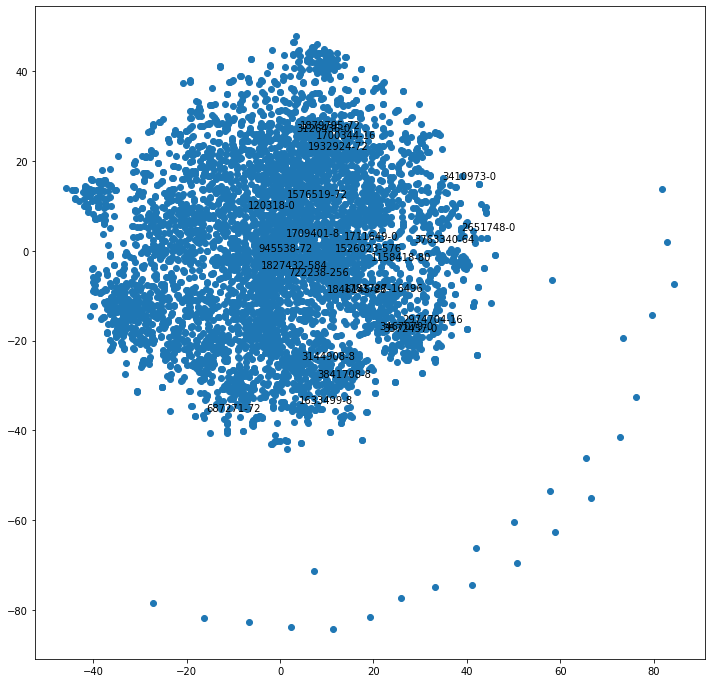

In [79]:
from sklearn.decomposition import IncrementalPCA  # inital reduction
from sklearn.manifold import TSNE  # final reduction
import numpy as np
import random
import matplotlib.pyplot as plt
import random
    
def reduce_dimensions(model):
    num_dimensions = 2
    
    # Limit points for performance
    n_points = 5000
    vectors_sub, labels_sub = zip(*random.sample(list(zip(model.wv.vectors, model.wv.index_to_key)), n_points))
    
    vectors = np.asarray(vectors_sub)
    labels = np.asarray(labels_sub)  # fixed-width numpy strings

    # reduce using t-SNE
    tsne = TSNE(n_components=num_dimensions, random_state=0)
    vectors = tsne.fit_transform(vectors)

    x_vals = [v[0] for v in vectors]
    y_vals = [v[1] for v in vectors]
    return x_vals, y_vals, labels

def plot_with_matplotlib(x_vals, y_vals, labels):
    random.seed(0)

    plt.figure(figsize=(12, 12))
    plt.scatter(x_vals, y_vals)

    # Label randomly subsampled 25 data points
    indices = list(range(len(labels)))
    selected_indices = random.sample(indices, 25)
    for i in selected_indices:
        plt.annotate(labels[i], (x_vals[i], y_vals[i]))

x_vals, y_vals, labels = reduce_dimensions(model)
plot_with_matplotlib(x_vals, y_vals, labels)

# Nearest Neighbors Prediction

In [6]:
from sklearn.neighbors import NearestNeighbors
import numpy as np

# word2vec_model = model
# else:
    # word2vec_model = gensim.models.Word2Vec.load("word2vec-pp/word2vec-pp")
model = gensim.models.Word2Vec.load("w2v_model/w2v_model")
model.wv.index_to_key[10000:20000]
# NN = NearestNeighbors(n_neighbors=5, algorithm='ball_tree').fit(word2vec_model.wv.vectors)

['1296966-64',
 '883754-0',
 '1036230-0',
 '361837-0',
 '935029-0',
 '82962-576',
 '3008181-0',
 '793727-0',
 '722525-8',
 '1353260-0',
 '763167-64',
 '1863246-0',
 '1854470-0',
 '1071565-8',
 '2037594-64',
 '547566-0',
 '1993380-72',
 '3967144-0',
 '3884667-24',
 '3557698-0',
 '1601399-0',
 '1177520-0',
 '3161319-0',
 '1315459-64',
 '1934828-0',
 '2178147-0',
 '502793-0',
 '2721301-0',
 '508558-0',
 '2344574-64',
 '2302615-64',
 '243487-0',
 '2213673-0',
 '2003655-0',
 '2134948-0',
 '1725575-0',
 '2151745-0',
 '3720482-64',
 '737100-0',
 '1410936-0',
 '2360394-0',
 '1539202-0',
 '1180209-584',
 '891293-0',
 '260022-0',
 '2245908-0',
 '1506912-0',
 '2025393-0',
 '2714678-0',
 '951635-0',
 '2153404-0',
 '1862002-0',
 '1992682-64',
 '1359006-0',
 '2505956-24',
 '257512-72',
 '2094974-0',
 '2467122-0',
 '959882-0',
 '3557430-0',
 '1175016-0',
 '74873-0',
 '1762730-24',
 '1206113-0',
 '2996734-0',
 '3539535-0',
 '876674-0',
 '2161926-16',
 '88074-0',
 '3743421-0',
 '1675832-72',
 '1568804-

In [77]:
import sys
sys.path.insert(0, "../")
from classes import Score
from osu_access_token import client_id, client_secret

user_id = '1009285'
api = Ossapi(client_id, client_secret)
top_scores = api.user_scores(user_id, type="best", mode="osu", limit=100)

top_scores = [Score(score) for score in top_scores]
top_scores.sort(key=lambda x: x.pp, reverse=True)

top_scores = [
    str(score.beatmap_id) + "-" + str(score.mods) for score in top_scores # Limit to top 50
]

top_scores_vec = [
    score for score in top_scores if score in word2vec_model.wv.index_to_key
]
top_scores_vec = [word2vec_model.wv[score] for score in top_scores_vec]

neighbor = NN.kneighbors([np.mean(top_scores_vec, axis=0)])

In [78]:
# Get the top 5 beatmaps
beatmaps = [model.wv.index_to_key[i] for i in neighbor[1][0]]
beatmaps = [beatmap for beatmap in beatmaps if beatmap not in top_scores]

beatmaps

['1635233-16', '2317225-16', '495633-16', '1570547-0', '2815257-16']

# Compare
Select random players at different pps from test set, and compare their top plays to avg pp of scores with predicted beatmap_id and pp combination

In [120]:
def compare(model, user_id, NN):
    """
    Selects users from the database, and compares their total_pp to average pp of model's recommended beatmpas.
    """
    # total_pp
    api = Ossapi(client_id, client_secret)
    user = api.user(user_id)
    pp = user.statistics.pp
    
    # average of recommended beatmaps
    top_scores = api.user_scores(user_id, type="best", mode="osu", limit=100)
    top_scores = [Score(score) for score in top_scores]
    top_scores.sort(key=lambda x: x.pp, reverse=True)
    top_scores = [
        str(score.beatmap_id) + "-" + str(score.mods) for score in top_scores
    ]  # Limit to top 50
    top_scores_vec = [
        score for score in top_scores if score in word2vec_model.wv.index_to_key
    ]
    top_scores_vec = [word2vec_model.wv[score] for score in top_scores_vec]
    neighbor = NN.kneighbors([np.mean(top_scores_vec, axis=0)])
    beatmaps = [model.wv.index_to_key[i] for i in neighbor[1][0]]

    conn = sqlite3.connect("../data/osu.db")
    cursor = conn.cursor()
    query = """SELECT pp from score where beatmap_id = ? and mods = ?"""
    cursor.execute(query, (beatmaps[0].split("-")[0], beatmaps[0].split("-")[1]))
    all_pp = cursor.fetchall()
    all_pp = [pp[0] for pp in all_pp]
    conn.close()
    
    print("User pp/20: ", pp/20)
    print("Avg.: ", sum(all_pp)/len(all_pp), "Beatmap pp: ", all_pp)

user_ids = ['13767572', '10073635', '8359561', '2944449', '9987634', '7236907', '12900463', '12363937', '13741560', '28956125', '13859779', '2146481', '24195234', '10577632'] 
# Manually randomly chosen user_ids with pp ranging from ~15k to ~2k
for user_id in user_ids:
    compare(model, user_id, NN)

User pp/20:  882.445
Avg.:  667.9246052631579 Beatmap pp:  [524.876, 670.859, 494.654, 854.063, 556.668, 758.116, 711.609, 828.041, 461.283, 686.441, 595.16, 876.938, 835.115, 487.559, 796.656, 673.378, 638.262, 724.05, 720.728, 878.267, 606.849, 750.204, 626.459, 628.836, 679.836, 583.539, 687.451, 822.389, 849.557, 546.688, 544.772, 679.862, 565.111, 712.735, 541.426, 574.026, 680.405, 528.267]
User pp/20:  823.1200000000001
Avg.:  809.3747941176471 Beatmap pp:  [611.053, 938.021, 977.136, 754.907, 946.511, 860.178, 939.696, 730.841, 781.942, 892.691, 854.598, 696.986, 896.099, 781.435, 723.073, 741.534, 996.708, 744.427, 1024.63, 717.077, 850.901, 777.507, 759.546, 963.595, 703.993, 697.545, 962.34, 740.812, 726.818, 727.507, 632.571, 839.923, 980.445, 545.697]
User pp/20:  790.39
Avg.:  809.3747941176471 Beatmap pp:  [611.053, 938.021, 977.136, 754.907, 946.511, 860.178, 939.696, 730.841, 781.942, 892.691, 854.598, 696.986, 896.099, 781.435, 723.073, 741.534, 996.708, 744.427, 1024